# Random Forest Classifier

# Setup
Let us import the required modules.

In [1]:
import time
import pandas as pd
import seaborn as sns

from loguru import logger
from sklearn.ensemble import RandomForestClassifier

import src.utilities.data_split as ds
import src.utilities.evaluation as eva
import src.utilities.model_selection as ms

## Load Data
Note that the dataset is already split into Train-Test sets.

In [2]:
data_split = ds.TrainTestSplit.from_csv_directory(dir_path="../data")

In [3]:
data_split.x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 358.9 MB


In [4]:
data_split.y_train.shape

(60000,)

## Tuning Discriminative Classifiers: Random Forest

Use a smaller dataset to reduce the workload of GridSearchCV

<AxesSubplot:ylabel='count'>

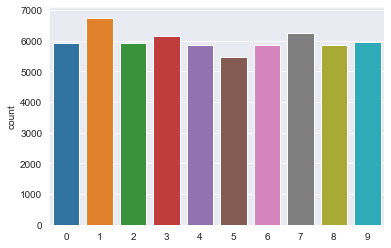

In [5]:
sns.countplot(x=data_split.y_train)

In [6]:
x_data_small, y_data_small = ds.get_train_subset(x_train=data_split.x_train, y_train=data_split.y_train, size=7000)

<AxesSubplot:xlabel='Number', ylabel='count'>

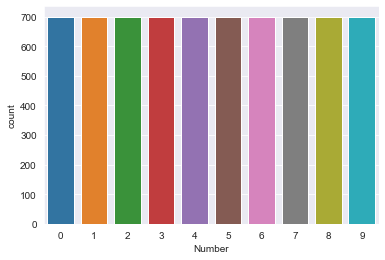

In [7]:
sns.countplot(x=y_data_small)

In [8]:
x_data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 45837 to 46255
Data columns (total 784 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel1    float64
 1    pixel2    float64
 2    pixel3    float64
 3    pixel4    float64
 4    pixel5    float64
 5    pixel6    float64
 6    pixel7    float64
 7    pixel8    float64
 8    pixel9    float64
 9    pixel10   float64
 10   pixel11   float64
 11   pixel12   float64
 12   pixel13   float64
 13   pixel14   float64
 14   pixel15   float64
 15   pixel16   float64
 16   pixel17   float64
 17   pixel18   float64
 18   pixel19   float64
 19   pixel20   float64
 20   pixel21   float64
 21   pixel22   float64
 22   pixel23   float64
 23   pixel24   float64
 24   pixel25   float64
 25   pixel26   float64
 26   pixel27   float64
 27   pixel28   float64
 28   pixel29   float64
 29   pixel30   float64
 30   pixel31   float64
 31   pixel32   float64
 32   pixel33   float64
 33   pixel34   float64
 34   pixel35   float64

In [9]:
y_data_small.shape

(7000,)

In [10]:
y_data_small

45837    0
977      0
17649    0
724      0
10982    0
        ..
43311    9
22049    9
4714     9
15110    9
46255    9
Name: Number, Length: 7000, dtype: int64

In [11]:
# automatic parameters tuning
rfclsf=RandomForestClassifier(random_state=28)
properties={
    "n_estimators": [x for x in range(50,201,50)],
    "min_samples_leaf": [x for x in range(50,201,50)],
    "max_leaf_nodes": [x for x in range(75,176,25)]
}

tuned_rfclsf = ms.model_selector(estimator=rfclsf,properties=properties,scoring="accuracy",cv=10,verbose=5,jobs=4,
                                  x_train=x_data_small,y_train=y_data_small)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 2/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=50;, score=(train=0.901, test=0.873) total time=   5.1s
[CV 6/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=50;, score=(train=0.901, test=0.899) total time=   3.6s
[CV 9/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=50;, score=(train=0.901, test=0.871) total time=   4.2s
[CV 3/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=100;, score=(train=0.907, test=0.890) total time=   7.9s
[CV 7/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=100;, score=(train=0.906, test=0.883) total time=  10.2s
[CV 2/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=150;, score=(train=0.908, test=0.880) total time=  15.6s
[CV 6/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=150;, score=(train=0.911, test=0.899) total time=  16.2s
[CV 9/10] END max_leaf_nodes=75, min_samples_leaf=50, n_estimators=150;,

2022-12-28 14:58:29.194 | INFO     | src.utilities.model_selection:model_selector:26 - --- 1441.3851199150085 seconds ---


In [12]:
# save results
ms.save_model(model=tuned_rfclsf, model_name="randforest_tuning_results")

In [13]:
# to load previously saved results
tuned_rfclsf = ms.load_model("randforest_tuning_results")

In [14]:
logger.info(tuned_rfclsf.cv_results_)
tuned_rfclsf_results = pd.DataFrame( tuned_rfclsf.cv_results_ )

2022-12-28 14:58:30.618 | INFO     | __main__:<module>:1 - {'mean_fit_time': array([ 4.22296278,  8.70229995, 15.47667506, 16.69964657,  3.03016224,
        4.9818481 ,  8.30098615, 11.17601273,  3.1030951 ,  6.39600928,
        7.9182807 ,  9.28548257,  2.20542915,  4.14645789,  6.27368975,
        7.45448241,  3.19554608,  6.00028872,  8.91893833, 12.058618  ,
        2.81341703,  5.18528988,  6.81638031,  9.27945821,  2.16198056,
        3.8224839 ,  5.90039806,  7.69464777,  2.21148887,  3.84358392,
        5.83300433,  7.02784662,  2.88580155,  5.54533453,  9.00083632,
       11.60541596,  2.84082301,  5.21415398,  7.16602533, 10.96855128,
        2.40160902,  5.75270629,  6.70514624,  9.07632198,  2.06256249,
        4.10530148,  6.23703501,  8.21026428,  3.17478445,  6.10836039,
        9.41968243, 12.20955904,  2.69127059,  5.46330318,  7.1976723 ,
        9.60930052,  2.54200101,  4.42266912,  8.81552022, 10.74796228,
        2.38519855,  3.37196658,  4.86882036,  6.01412418, 

In [15]:
tuned_rfclsf_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,"{'max_leaf_nodes': 75, 'min_samples_leaf': 50,...",0.879714,0.901762
1,"{'max_leaf_nodes': 75, 'min_samples_leaf': 50,...",0.885857,0.907698
2,"{'max_leaf_nodes': 75, 'min_samples_leaf': 50,...",0.887143,0.909889
3,"{'max_leaf_nodes': 75, 'min_samples_leaf': 50,...",0.888571,0.910190
4,"{'max_leaf_nodes': 75, 'min_samples_leaf': 100...",0.851143,0.868063
...,...,...,...
75,"{'max_leaf_nodes': 175, 'min_samples_leaf': 15...",0.840857,0.855873
76,"{'max_leaf_nodes': 175, 'min_samples_leaf': 20...",0.802143,0.817143
77,"{'max_leaf_nodes': 175, 'min_samples_leaf': 20...",0.813857,0.827111
78,"{'max_leaf_nodes': 175, 'min_samples_leaf': 20...",0.819429,0.834190


<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

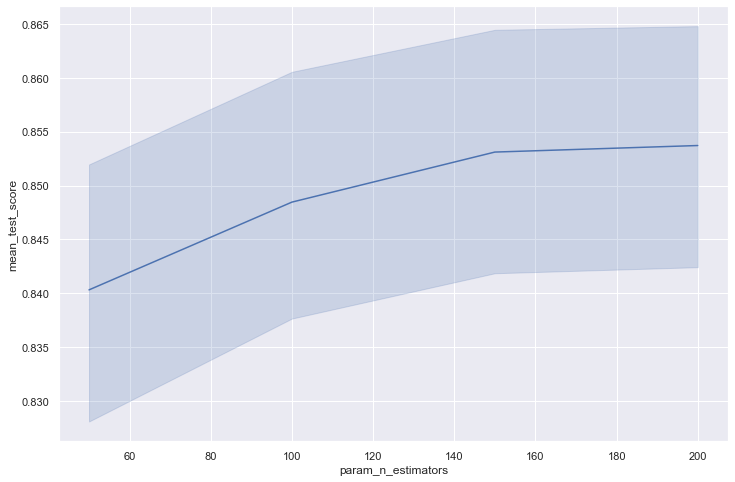

In [16]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_rfclsf_results, x="param_n_estimators", y="mean_test_score")

<AxesSubplot:xlabel='param_max_leaf_nodes', ylabel='mean_test_score'>

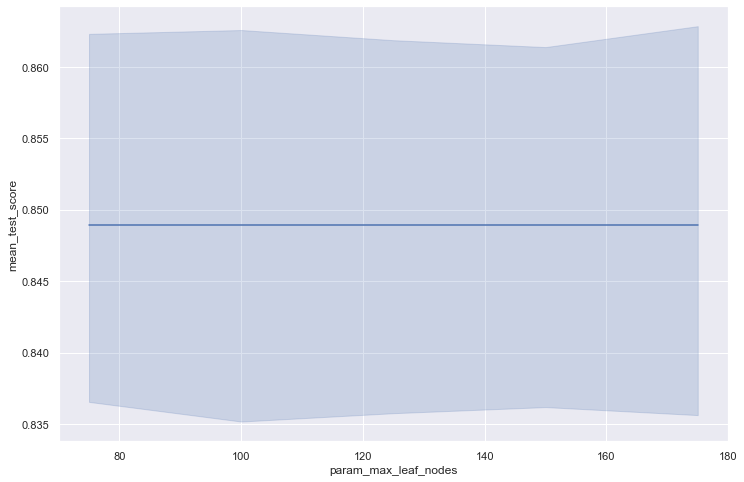

In [17]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_rfclsf_results, x="param_max_leaf_nodes", y="mean_test_score")

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

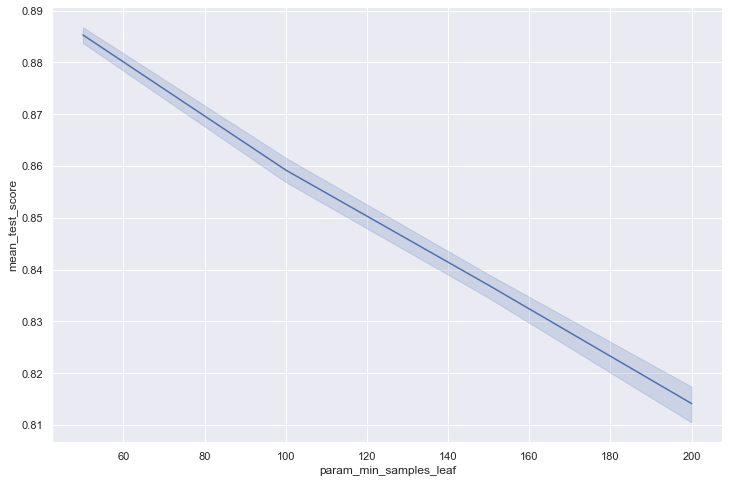

In [18]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_rfclsf_results, x="param_min_samples_leaf", y="mean_test_score")

In [19]:
print(tuned_rfclsf.best_estimator_)
print(tuned_rfclsf.best_score_)

RandomForestClassifier(max_leaf_nodes=75, min_samples_leaf=50, n_estimators=200,
                       random_state=28)
0.8885714285714286


## Model Training

In [20]:
# best parameters from automatic parameters tuning
start_time = time.time()
rf_clsf = RandomForestClassifier(**tuned_rfclsf.best_params_)
rf_clsf.fit(data_split.x_train, data_split.y_train)
logger.info("Training: - %s seconds -" % (time.time() - start_time))

2022-12-28 15:00:04.059 | INFO     | __main__:<module>:5 - Training: - 90.1204719543457 seconds -


# Performance

In [21]:
start_time = time.time()
rf_test_pred = rf_clsf.predict(data_split.x_test)
logger.info("Prediction: - %s seconds -" % (time.time() - start_time))
rfreg_test_eval = eva.Evaluation(y_true=data_split.y_test, y_pred=rf_test_pred)

2022-12-28 15:03:03.290 | INFO     | __main__:<module>:3 - Prediction: - 1.914968729019165 seconds -


In [22]:
print("Testing:")
rfreg_test_eval.acc_eval()

Testing:
-----Model Evaluations:-----
Accuracy score: 0.9039


In [23]:
# save the model and evaluations
rf_model = eva.EvaluatedModel(rf_clsf, "randomforest", test_eval=rfreg_test_eval)
rf_model.save_evaluation()

In [24]:
# load the previously saved model and evaluations
rf_model = eva.EvaluatedModel.load_evaluation("randomforest")

### Confusion Matrix

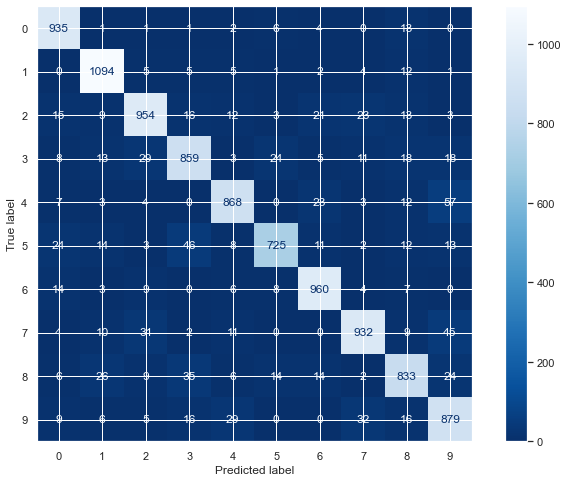

In [26]:
rf_model.test_eval.conf_mat()